In [21]:
%matplotlib inline
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
import random

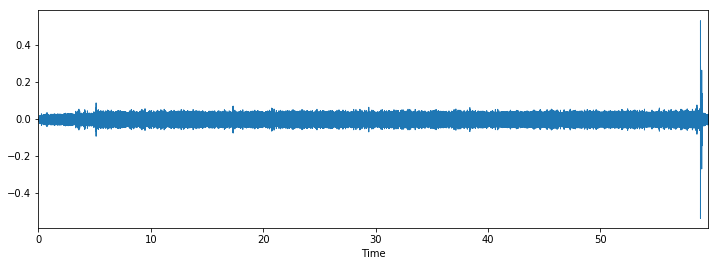

In [87]:
# Loading idle fan sound
data_wn, sampling_rate_wn = librosa.load('./idlefan2.wav')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data_wn, sr=sampling_rate_wn)

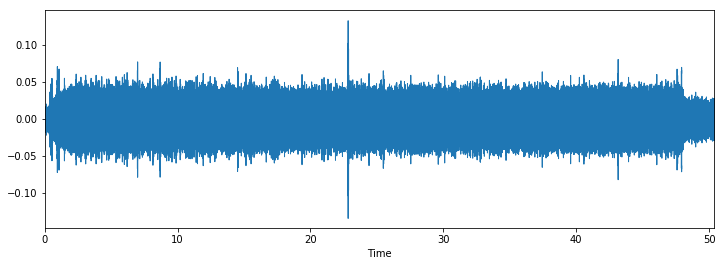

In [88]:
# Loading scratching sound
data, sampling_rate = librosa.load('./positive_data.wav')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [89]:
# By listening to the files, I picked out some times. Positive file has 0-16s, 22-44s. Negative is 5-18s.
slices_positive = []
for i in range(4):
    idx_0 = 4*sampling_rate * i
    idx_1 = 4*sampling_rate * (i+1)
    slices_positive.append(data[idx_0:idx_1])
for i in range(5):
    idx_0 = 4*sampling_rate * i + 22*sampling_rate
    idx_1 = 4*sampling_rate * (i+1) + 22*sampling_rate
    slices_positive.append(data[idx_0:idx_1])
    
slices_wn = []
for i in range(3):
    idx_0 = 4*sampling_rate_wn * i + 5 * sampling_rate_wn
    idx_1 = 4*sampling_rate_wn * (i+1) + 5 * sampling_rate_wn
    slices_wn.append(data_wn[idx_0:idx_1])

In [92]:
# setting up the values
# Encode
lb = LabelEncoder()
classifiers = ["scratch", "background"]

X = [np.mean(librosa.feature.mfcc(y=X, sr=sampling_rate, n_mfcc=40).T,axis=0)  for X in slices_positive + slices_wn]
y_total = [classifiers[0]]* len(slices_positive) + [classifiers[1]]* len(slices_wn)
y_total = np_utils.to_categorical(lb.fit_transform(y_total))

rand = list(zip(X,y_total))
random.shuffle(rand) 

X = np.array([i[0] for i in rand[:7]])
val_x = np.array([i[0] for i in rand[7:]])
y = np.array([i[1] for i in rand[:7]])
val_y = np.array([i[1] for i in rand[7:]])
num_labels = y.shape[1]
filter_size = 2

(40,)

In [31]:


# build model
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [32]:
model.fit(X, y, batch_size=32, epochs=5, validation_data=(val_x, val_y))

Train on 7 samples, validate on 5 samples
Epoch 1/5
7/7 [==============================] - 0s 52ms/step - loss: 11.5129 - acc: 0.2857 - val_loss: 6.4472 - val_acc: 0.6000
Epoch 2/5
7/7 [==============================] - 0s 714us/step - loss: 5.9768 - acc: 0.5714 - val_loss: 6.4472 - val_acc: 0.6000
Epoch 3/5
7/7 [==============================] - 0s 286us/step - loss: 2.3026 - acc: 0.8571 - val_loss: 6.4472 - val_acc: 0.6000
Epoch 4/5
7/7 [==============================] - 0s 286us/step - loss: 5.2795 - acc: 0.5714 - val_loss: 6.4472 - val_acc: 0.6000
Epoch 5/5
7/7 [==============================] - 0s 428us/step - loss: 5.5337 - acc: 0.5714 - val_loss: 6.4472 - val_acc: 0.6000


In [8]:
model.save("model_.h5")

In [74]:
# model = load_model("model_.h5")
print(X[0:1].shape)

(1, 40)


In [102]:
import pyaudio
import wave
import time
import sys
import collections

CHUNK = 1024
RATE = 44100
RECORD_SECONDS = 5
MAX_BUFFER = 4*22050
p = pyaudio.PyAudio()
Ringbuffer = collections.deque(maxlen=MAX_BUFFER)

def callback(in_data, frame_count, time_info, status):
    audio_data = np.frombuffer(in_data, dtype=np.float32)
    audio_data = librosa.resample(audio_data, RATE, sampling_rate)

    Ringbuffer.extend(audio_data)
    if len(Ringbuffer) >= MAX_BUFFER:        
        data_live = np.array(np.mean(librosa.feature.mfcc(y=np.array(list(Ringbuffer)), sr=sampling_rate, n_mfcc=40).T,axis=0)) 
        guess = model.predict(np.reshape(data_live,(1,40)), verbose=1).argmax(1)[0]
        if guess == 0:
            print("Scratching")

    return (audio_data, pyaudio.paContinue)

stream = p.open(format = pyaudio.paFloat32,
                channels=1,
                rate = RATE,
                input=True,
                stream_callback=callback)

stream.start_stream()

# while stream.is_active():
#     time.sleep(0.1)
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    time.sleep(0.1)


stream.stop_stream()
stream.close()

p.terminate()

1/1 [==============================] - 0s 999us/step


1/1 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 0us/step


IndexError: index 100 is out of bounds for axis 0 with size 10